In [2]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf, keras
from datetime import timedelta

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# for graphing
import plotly.express as px

# visualizing the network
%load_ext tensorboard
import datetime



In [3]:
df = pd.read_csv("loan_history.csv")
model_data = df[df.columns]

# convert to datetime for date calculations
model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']] = model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']].apply(pd.to_datetime)

# create column for the number of days it took to repay the loan
model_data['paybackDuration'] = (model_data["loanRepaidDate"] - model_data["loanCreatedAt"]).dt.days

# create col for the number of days it was overdue (negative numbers means it was paid on time)
model_data['daysOverdue'] = (model_data['repaymentDate'] - model_data["loanRepaidDate"]) * -1

# fix NaN values
model_data[['paybackDuration', 'daysOverdue']] = model_data[['paybackDuration', 'daysOverdue']].fillna(pd.Timedelta(days=0))

# check to make sure im not crazy and some loan creation dates are before the repayment date
model_data['sanityCheck'] = (model_data['loanCreatedAt'] - model_data["repaymentDate"])

model_data['interestPercent'] = (model_data['interestOnLoan'] / model_data['loanAmount']) * 100

# create labels for supervised learning, >14 days overdue is a default(NOT DEFAULT: 0, DEFAULT: 1)
model_data.loc[model_data['daysOverdue'] < timedelta(14), 'target'] = 0
model_data.loc[model_data['daysOverdue'] >= timedelta(14), 'target'] = 1

model_data['daysOverdue'] = (model_data['daysOverdue'].dt.days).astype(float)
model_data['sanityCheck'] = (model_data['sanityCheck'].dt.days).astype(float)


In [26]:
# features to use in the nn
quant_features = ['customerAge', 'loanAmount', 'interestPercent', 'daysOverdue']
qual_features = ['maritalStatus', 'educationLevel', 'location']

# drop unused columns
model_data = model_data.drop(columns=['customerId', 'repaymentDate', 'loanRepaidDate', 'loanStatus', 'loanCreatedAt', 'paybackDuration'])
model_data.describe()

# keep for distribution comparisons
old_model_data = model_data.copy()

In [27]:
# fix skewed data
model_data[['loanAmount', 'customerAge', 'interestOnLoan']] = np.log(model_data[['loanAmount', 'customerAge', 'interestOnLoan']])
model_data['interestPercent'] = np.sqrt(model_data['interestPercent'])

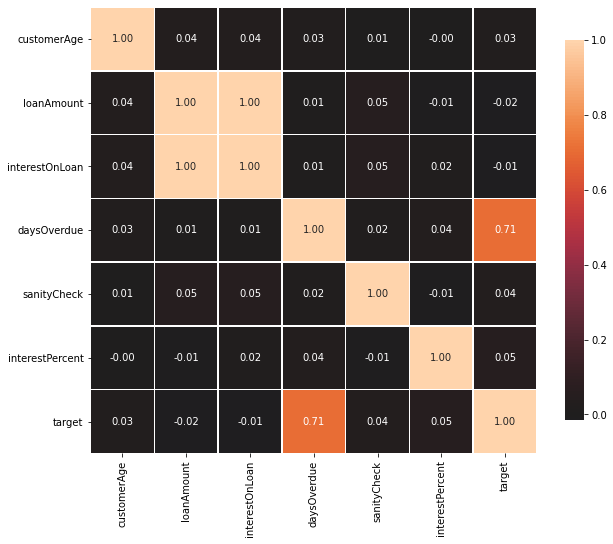

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# spearman correlation
def correlation_heatmap(data):
	correlations = data.corr()

	fig, ax = plt.subplots(figsize=(10, 10))
	sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
				square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.70})
	plt.show();
correlation_heatmap(model_data)


In [29]:
# drop interest on loan bc spearman correlation shows its redundant
model_data = model_data.drop(columns=['interestOnLoan'])

In [30]:
# split into train, test, and validation
train, test = train_test_split(model_data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2150 train examples
538 validation examples
673 test examples


In [31]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = model_data.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [32]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [33]:
# create a one-hot encoding for the categoriacal features
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [34]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

all_inputs = []
encoded_features = []

# Numeric features.
for header in quant_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Categorical features encoded as string.
for header in qual_features:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=4)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


In [35]:
from tensorflow.keras.optimizers import Adam # optimizer
# create the neural network
all_features = tf.keras.layers.concatenate(encoded_features)
input_layer = tf.keras.layers.Dense(32, activation="relu")(all_features)
dropout = tf.keras.layers.Dropout(0.5)(input_layer) # account for overfitting
output = tf.keras.layers.Dense(1)(dropout)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [36]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tensorboard_callback])

%tensorboard --logdir logs/fit
# clear logs
# rm -rf /logs

Epoch 1/10


/Users/zacharycoriarty/Library/Python/3.8/lib/python/site-packages/keras/engine/functional.py:582: UserWarning:

Input dict contained keys ['sanityCheck'] which did not match any model input. They will be ignored by the model.



14/14 [==============================] - 1s 47ms/step - loss: nan - accuracy: 0.9860 - val_loss: nan - val_accuracy: 0.9860
Epoch 2/10
14/14 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.9860 - val_loss: nan - val_accuracy: 0.9860
Epoch 3/10
14/14 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.9860 - val_loss: nan - val_accuracy: 0.9860
Epoch 4/10
14/14 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.9860 - val_loss: nan - val_accuracy: 0.9860
Epoch 5/10
14/14 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.9860 - val_loss: nan - val_accuracy: 0.9860
Epoch 6/10
14/14 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.9860 - val_loss: nan - val_accuracy: 0.9860
Epoch 7/10
14/14 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.9860 - val_loss: nan - val_accuracy: 0.9860
Epoch 8/10
14/14 [==============================] - 0s 5ms/step - loss: 

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

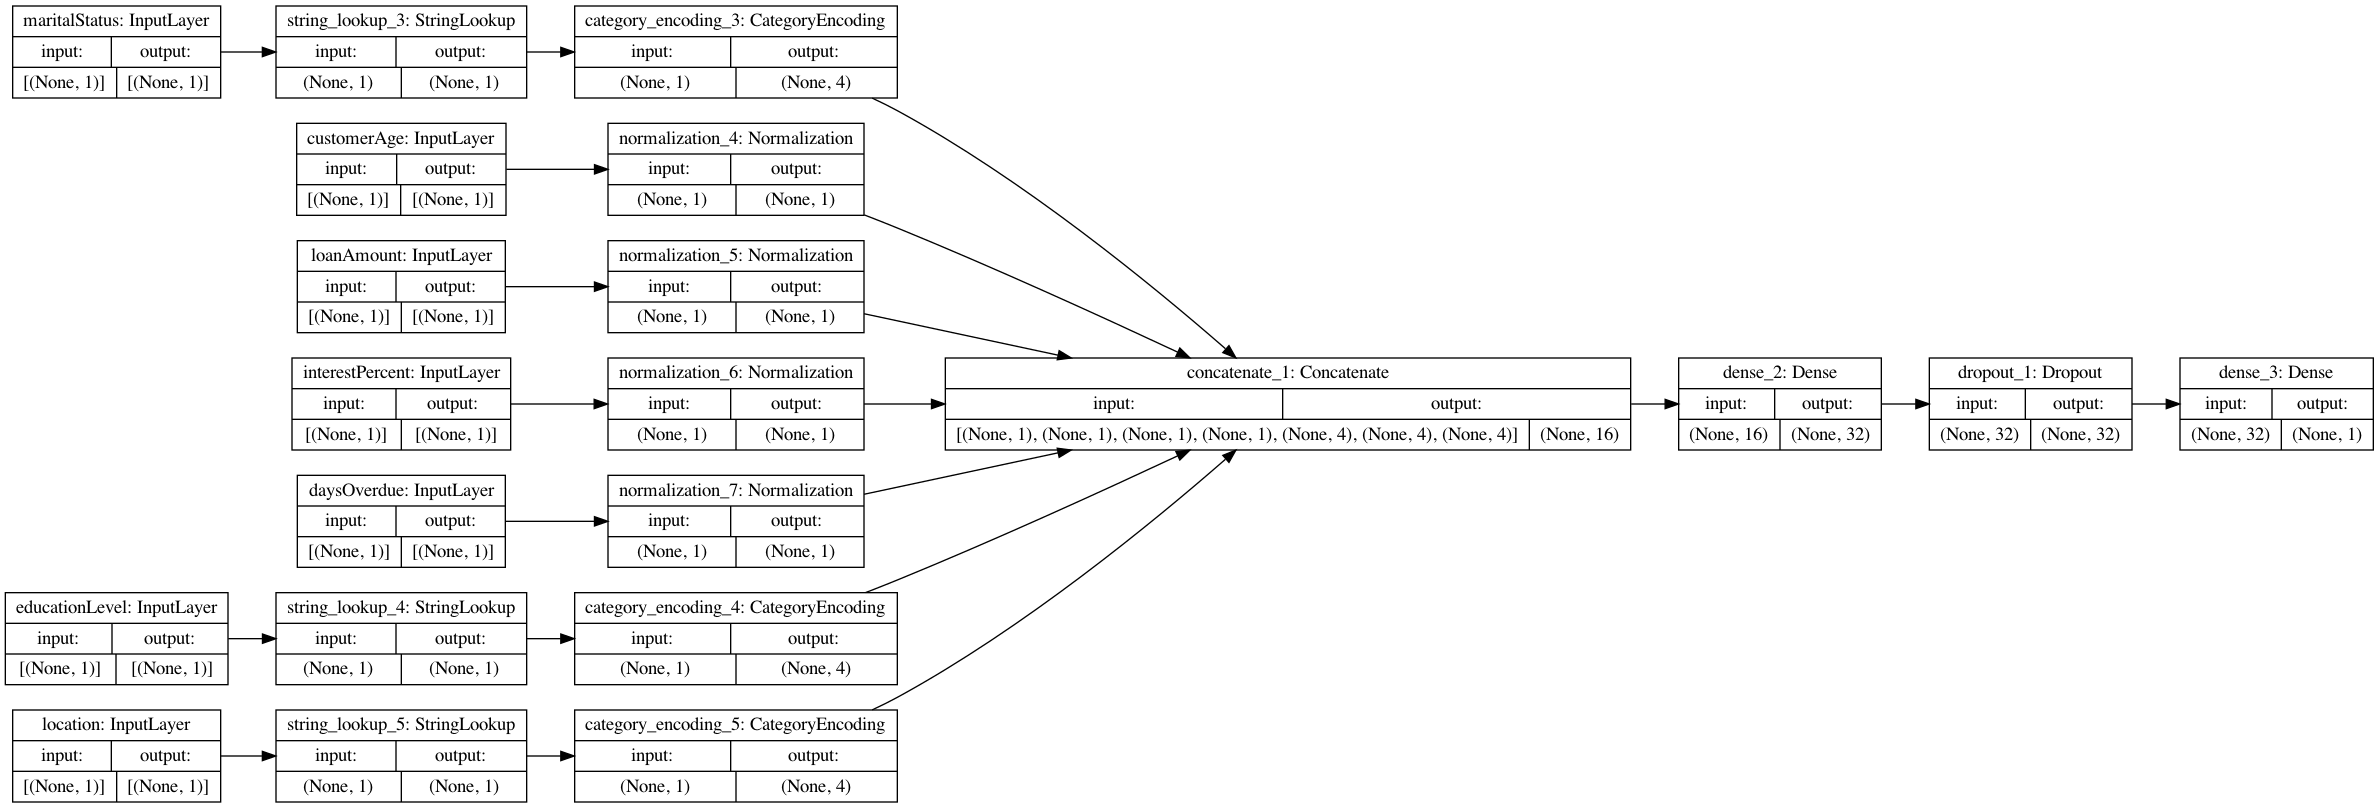

In [37]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [38]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
print("Loss", loss)

14/14 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9860
Accuracy 0.9860160946846008
Loss nan


In [39]:
# save the model and load it
model.save('loan-predictor')
reloaded_model = tf.keras.models.load_model('loan-predictor')

INFO:tensorflow:Assets written to: loan-predictor/assets


INFO:tensorflow:Assets written to: loan-predictor/assets


In [40]:
# used for making predictions and gives the probability of it belonging to a certain class(default, not default)
def predict(data):
	data = data.to_dict()
	input_dict = {name: tf.convert_to_tensor([value]) for name, value in data.items()}
	predictions = reloaded_model.predict(input_dict)
	prob = tf.nn.sigmoid(predictions[0])

	return prob

prediction = predict(test.iloc[3]) # need to change precision for output
print("There is a %.2f%% change the loan will default for this customer." % (100 * prediction))

There is a nan% change the loan will default for this customer.


/Users/zacharycoriarty/Library/Python/3.8/lib/python/site-packages/keras/engine/functional.py:582: UserWarning:

Input dict contained keys ['sanityCheck', 'target'] which did not match any model input. They will be ignored by the model.



## Distribution Analysis

In [41]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# comparison between skewed data and transformed data
for col in ['loanAmount', 'customerAge', 'interestPercent']:
	fig = make_subplots(rows=1, cols=2)
	trace1 = go.Histogram(x=old_model_data[col])
	trace2 = go.Histogram(x=model_data[col])
	print(trace2)
	fig.append_trace(trace1, row=1, col=1)
	fig.append_trace(trace2, row=1, col=2)
	fig.update_layout(title_text=str(col))
	fig.show()  



Histogram({
    'x': array([10.81977828, 10.81977828, 10.81977828, ..., 10.75577295,
           9.85744361, 10.81977828])
})


Histogram({
    'x': array([3.61091791, 4.04305127, 3.78418963, ..., 3.4339872 , 3.36729583,
          3.17805383])
})


Histogram({
    'x': array([2.44948974, 2.44948974, 2.44948974, ..., 2.40138997, 2.40138485,
          2.44948974])
})
